In [8]:
import pathlib
import seaborn as sns
import utils
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [4]:
url = 'https://glusfqycvwrucp9-db202202211424.adb.eu-zurich-1.oraclecloudapps.com/ords/sensor_datalake1/sens/insert/'

df = utils.get_all_pages(url)



In [5]:
df.head()

,entry_id,insert_time,sensor_id,value1,unit1
0,2291,2022-03-30T14:49:51.283Z,CIRCUITPY323d,785.0,PPM
1,2304,2022-03-30T14:56:37.668Z,CIRCUITPY323d,27.4,C
2,2307,2022-03-30T14:57:37.983Z,CIRCUITPY323d,27.4,C
3,2311,2022-03-30T14:58:40.293Z,CIRCUITPY323d,31.1,%
4,2328,2022-03-30T15:04:41.298Z,CIRCUITPY323d,27.7,C


In [6]:
#convert inser_time to timedate
df['insert_time'] = pd.to_datetime(df['insert_time'])
#and add 2 hours to insert time
df['insert_time'] = df['insert_time'] + pd.Timedelta(hours=2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96741 entries, 0 to 96740
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   entry_id     96741 non-null  int64              
 1   insert_time  96741 non-null  datetime64[ns, UTC]
 2   sensor_id    96741 non-null  object             
 3   value1       96741 non-null  float64            
 4   unit1        96741 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [10]:
#pivot
df_pivot = df.pivot_table(index='insert_time',columns=['sensor_id','unit1'],values='value1')
#multindex to single index
df_pivot.columns =	df_pivot.columns.map('_'.join)
#resample on 5min time windows

df_pivot = df_pivot.resample('1Min').agg({'CIRCUITPY323d_PPM':'mean', 'CIRCUITPY323d_C':'mean','CIRCUITPY323d_%':'mean','CIRCUITPY323d_%':'mean','CIRCUITPY825a_Window':'last','CIRCUITPYbec9_Person':'last'})
df_pivot.head(30)

,CIRCUITPY323d_PPM,CIRCUITPY323d_C,CIRCUITPY323d_%,CIRCUITPY825a_Window,CIRCUITPYbec9_Person
insert_time,,,,,
2022-03-24 16:02:00+00:00,1068.800000,26.600000,34.600000,0.0,NaN
2022-03-24 16:03:00+00:00,1073.700000,26.500000,32.500000,NaN,NaN
2022-03-24 16:04:00+00:00,1061.600000,26.400000,33.450000,NaN,NaN
2022-03-24 16:05:00+00:00,1072.400000,26.400000,33.950000,NaN,NaN
2022-03-24 16:06:00+00:00,1115.650000,26.400000,34.150000,NaN,NaN
2022-03-24 16:07:00+00:00,1145.600000,26.400000,34.700000,NaN,NaN
2022-03-24 16:08:00+00:00,1142.450000,26.400000,35.000000,NaN,NaN
2022-03-24 16:09:00+00:00,1152.500000,26.400000,35.550000,NaN,NaN
2022-03-24 16:10:00+00:00,1200.900000,26.400000,35.850000,NaN,NaN


In [12]:
#neue Variable die die Luftqualität Quantitativ einordnet
df_pivot['air_quality'] =np.where(df_pivot['CIRCUITPY323d_PPM']>600, 'good',
                   np.where(df_pivot['CIRCUITPY323d_PPM']>1000, 'ok',
                   np.where(df_pivot['CIRCUITPY323d_PPM']>1400, 'bad', 'top')))


In [49]:
#select specific time window
df_timewindow = df_pivot.loc['2022-04-23 00:00:00':'2022-04-23 23:50:00']

In [40]:
#Fill Nan for window sensor
df_timewindow['CIRCUITPY825a_Window'].fillna(method='ffill',inplace=True)
df_timewindow['CIRCUITPY825a_Window'].fillna(method='bfill',inplace=True)
#Fill Nan for people sensor
df_timewindow['CIRCUITPYbec9_Person'].fillna(method='ffill',inplace=True)
#Fill Nan for first entry for people sensor
df_timewindow['CIRCUITPYbec9_Person'].fillna(method='bfill',inplace=True)

df_timewindow.head(5)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,CIRCUITPY323d_PPM,CIRCUITPY323d_C,CIRCUITPY323d_%,CIRCUITPY825a_Window,CIRCUITPYbec9_Person,air_quality
insert_time,,,,,,
2022-04-23 18:00:00+00:00,579.4,25.3,41.3,1.0,1.0,top
2022-04-23 18:01:00+00:00,579.0,25.3,41.4,1.0,1.0,top
2022-04-23 18:02:00+00:00,566.9,25.2,40.9,1.0,1.0,top
2022-04-23 18:03:00+00:00,486.9,25.1,39.8,1.0,1.0,top
2022-04-23 18:04:00+00:00,449.4,25.0,39.1,1.0,1.0,top


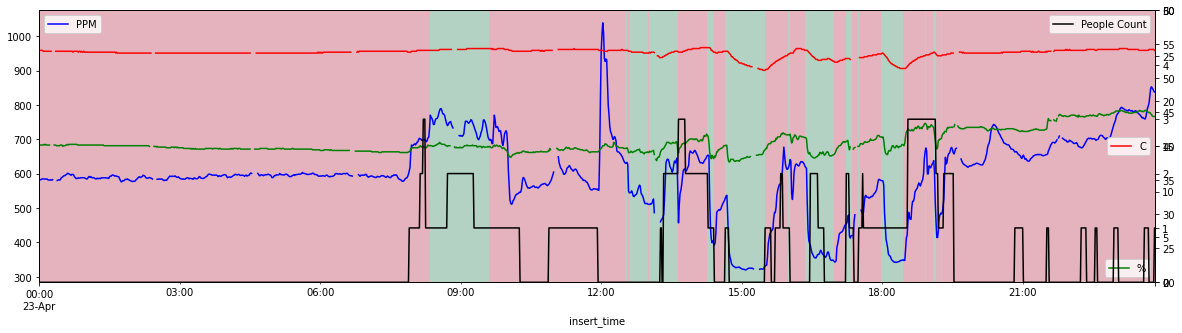

In [50]:
#linechart cobined with bar chart
#if windows sensor 1 blue line if windows sensor 0 red line
# Use a boundary norm instead
fig, ax1 = plt.subplots()
#hide grid
ax1 = df_timewindow['CIRCUITPY323d_PPM'].plot(kind='line',color='blue',label='PPM', grid=False)
ax3 = ax1.twinx()
ax3 = df_timewindow['CIRCUITPY323d_C'].plot(kind='line',color='red',label='C', grid=False,ylim=(0,30))
ax4 = ax1.twinx()
ax4 = df_timewindow['CIRCUITPY323d_%'].plot(kind='line',color='green',label='%', grid=False,ylim=(20,60))
ax2 = ax1.twinx()
ax2 = df_timewindow['CIRCUITPYbec9_Person'].plot(kind='line',color='black',label='People Count',ylim=(0,5))
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),df_timewindow['CIRCUITPY825a_Window'].values[np.newaxis],cmap='RdYlGn', alpha=0.3,label='Windows')
#set size
ax1.figure.set_size_inches(20, 5)
#show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='center right')
ax4.legend(loc='lower right')
#additonal legend for window sensor


plt.show()

In [42]:
#calculate correleation between two columns
df_timewindow.corr(method="spearman")

,CIRCUITPY323d_PPM,CIRCUITPY323d_C,CIRCUITPY323d_%,CIRCUITPY825a_Window,CIRCUITPYbec9_Person
CIRCUITPY323d_PPM,1.000000,0.978523,-0.094305,NaN,NaN
CIRCUITPY323d_C,0.978523,1.000000,-0.103575,NaN,NaN
CIRCUITPY323d_%,-0.094305,-0.103575,1.000000,NaN,NaN
CIRCUITPY825a_Window,NaN,NaN,NaN,NaN,NaN
CIRCUITPYbec9_Person,NaN,NaN,NaN,NaN,NaN


In [43]:
#calculate correleation between two columns
df_timewindow.corr(method="pearson")

,CIRCUITPY323d_PPM,CIRCUITPY323d_C,CIRCUITPY323d_%,CIRCUITPY825a_Window,CIRCUITPYbec9_Person
CIRCUITPY323d_PPM,1.000000,0.890530,0.589598,NaN,NaN
CIRCUITPY323d_C,0.890530,1.000000,0.190288,NaN,NaN
CIRCUITPY323d_%,0.589598,0.190288,1.000000,NaN,NaN
CIRCUITPY825a_Window,NaN,NaN,NaN,NaN,NaN
CIRCUITPYbec9_Person,NaN,NaN,NaN,NaN,NaN


Janis Ideen data wrangling

In [44]:
df_timewindow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2022-04-23 18:00:00+00:00 to 2022-04-23 18:20:00+00:00
Freq: T
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CIRCUITPY323d_PPM     21 non-null     float64
 1   CIRCUITPY323d_C       21 non-null     float64
 2   CIRCUITPY323d_%       21 non-null     float64
 3   CIRCUITPY825a_Window  21 non-null     float64
 4   CIRCUITPYbec9_Person  21 non-null     float64
 5   air_quality           21 non-null     object 
dtypes: float64(5), object(1)
memory usage: 1.1+ KB


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


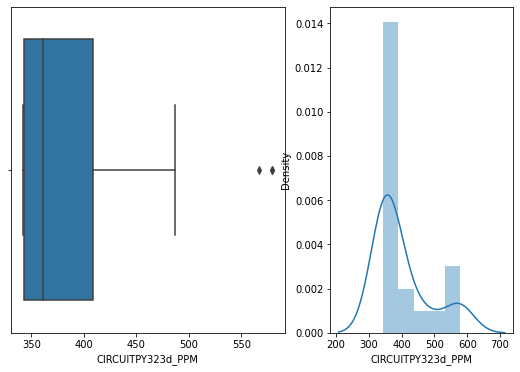

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


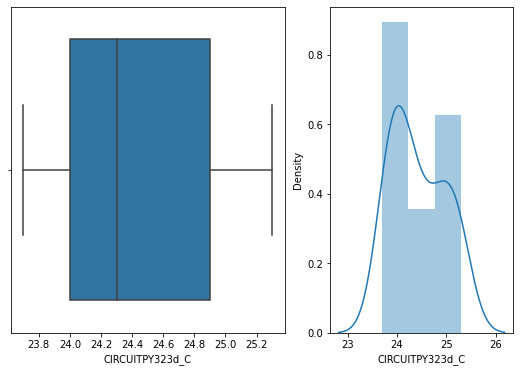

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


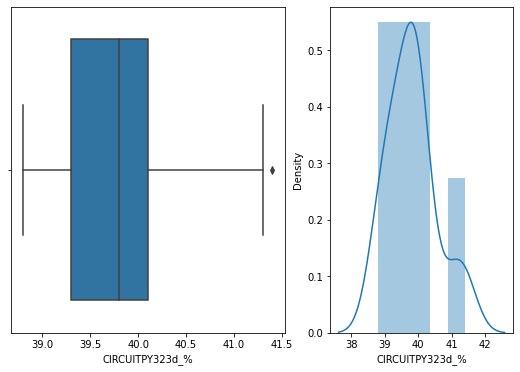

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWar

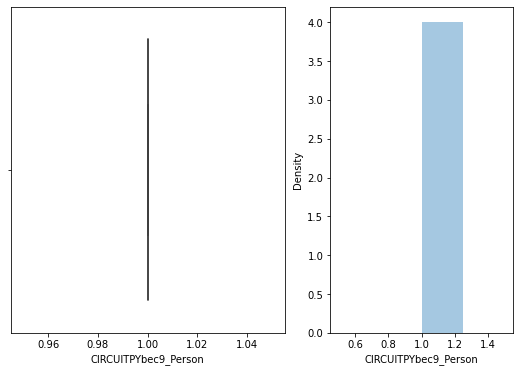

In [45]:
#detect outliers in PPM data
#print boxlot
utils.overview(df_timewindow, "CIRCUITPY323d_PPM")
utils.overview(df_timewindow, "CIRCUITPY323d_C")
utils.overview(df_timewindow, "CIRCUITPY323d_%")
utils.overview(df_timewindow, "CIRCUITPYbec9_Person")

In [46]:
print(df_timewindow['CIRCUITPY323d_PPM'].max())
print(df_timewindow['CIRCUITPY323d_PPM'].min())

579.4
342.1


In [47]:
df_ppm_high = pd.DataFrame
df_ppm_high = df_timewindow[df_timewindow["air_quality"] == "high"]

In [48]:
df_ppm_high

,CIRCUITPY323d_PPM,CIRCUITPY323d_C,CIRCUITPY323d_%,CIRCUITPY825a_Window,CIRCUITPYbec9_Person,air_quality
insert_time,,,,,,
